In [4]:
%matplotlib inline

## Importation des modules

In [5]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas LukoÅ¡eviÄ?ius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
#from numpy import *
import numpy as np
#from matplotlib.pyplot import *
import matplotlib.pyplot as plt
#import scipy.linalg
from scipy import linalg
#from numpy import linalg
from ipywidgets import *

## Remise à zéro de l'aléatoire

In [6]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    # Set the seed
    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Création d'une classe "Réseau"

In [34]:
class Reseau(object) :
    
    def __init__(self, a=0.03) :
        self.a = a
        self.spectral_radius = 1.25
        self.input_scaling = 1.
        self.resSize = 300
        self.inSize = 1
        self.outSize = 1
        self.reg =  1e-8

## Chargement des données

In [35]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100

data = np.loadtxt('MackeyGlass_t17.txt')

## Affichage dynamique d'un échantillon de données

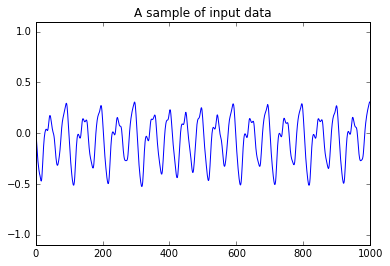

In [36]:
# plot some of it
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(data[0:f])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    plt.show()
    
interact(plot_figure, f=(1000,10000,1000))

## Variables

In [37]:
# generate the ESN reservoir
inSize = outSize = 1 #input/output dimension
resSize = 300 #reservoir size (for prediction)
#resSize = 1000 #reservoir size (for generation)
a = 0.3 # leaking rate
spectral_radius = 1.25
input_scaling = 1.
reg =  1e-8 #None # regularization coefficient, if None, pseudo-inverse is use instead of ridge regression
mode = 'prediction'
#mode = 'generative'

In [42]:
#class reseau1 variables
reseau1 = Reseau()
reseau1.Win = (np.random.rand(reseau1.resSize,1+reseau1.inSize)-0.5) * reseau1.input_scaling
reseau1.W = np.random.rand(reseau1.resSize,reseau1.resSize)-0.5
reseau1.rhoW = max(abs(linalg.eig(reseau1.W)[0]))
reseau1.W *= reseau1.spectral_radius / rhoW

In [39]:
#change the seed, reservoir performances should be averaged accross
#at least 20 random instances (with the same set of parameters)
seed = None #42
set_seed(seed) #random.seed(seed) 

Win = (np.random.rand(resSize,1+inSize)-0.5) * input_scaling
W = np.random.rand(resSize,resSize)-0.5

# Option 1 - direct scaling (quick&dirty, reservoir-specific):
#W *= 0.135 

# Option 2 - normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...',)
rhoW = max(abs(linalg.eig(W)[0]))
#np_rhoW = max(abs(np.linalg.eig(W)[0]))
#print "Difference between scipy and numpy .eig() method: scipy="+str(rhoW)+" numpy="+str(np_rhoW)
print('done.')
W *= spectral_radius / rhoW

Seed used for random values: 1692829892
Computing spectral radius...
done.


In [41]:
# allocated memory for the design (collected states) matrix
reseau1.X = np.zeros((1+inSize+resSize,trainLen-initLen))
print("Taille de X :", X.shape, "- Eléments :", X.size)

# set the corresponding target matrix directly
reseau1.Yt = data[None,initLen+1:trainLen+1] 
print("Taille de Yt :", Yt.shape)

# run the reservoir with the data and collect X
reseau1.x = np.zeros((resSize,1))
print("Taille de x :", x.shape)

def reseau(data, res, initLen) :
    for t in range(trainLen):
        u = data[t]
        res.x = (1-res.a)*x + res.a*np.tanh( np.dot( res.Win, np.vstack((1,u)) ) + np.dot( res.W, res.x ) )
        if t >= initLen:
            res.X[:,t-initLen] = np.vstack((1,u,res.x))[:,0]
            
reseau(data, reseau1, initLen)

Taille de X : (302, 1900) - Eléments : 573800
Taille de Yt : (1, 1900)
Taille de x : (300, 1)


In [17]:
# train the output
reseau1.X_T = reseau1.X.T
if reg is not None:
    # use ridge regression (linear regression with regularization)
    reseau1.Wout = np.dot(np.dot(reseau1.Yt,reseau1.X_T), linalg.inv(np.dot(reseau1.X,reseau1.X_T) + \
        reg*np.eye(1+reseau1.inSize+reseau1.resSize) ) )
    ### Just if you want to try the difference between scipy.linalg and numpy.linalg which does not give the same results
        ### For more info, see 
        ### https://www.scipy.org/scipylib/faq.html#why-both-numpy-linalg-and-scipy-linalg-what-s-the-difference
#    np_Wout = np.dot(np.dot(Yt,X_T), np.linalg.inv(np.dot(X,X_T) + \
#        reg*np.eye(1+inSize+resSize) ) )
#    print "Difference between scipy and numpy .inv() method:\n\tscipy_mean_Wout="+\
#        str(np.mean(Wout))+"\n\tnumpy_mean_Wout="+str(np.mean(np_Wout))
else:
    # use pseudo inverse
    reseau1.Wout = np.dot( reseau1.Yt, linalg.pinv(reseau1.X) )

In [18]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
reseau1.Y = np.zeros((outSize,testLen))
u = data[trainLen]

def rereseau(data, res, initLen) :
    for t in range(testLen):
        res.x = (1-res.a)*res.x + res.a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( res.W, res.x ) )
        res.y = np.dot( res.Wout, np.vstack((1,u,res.x)) )
        res.Y[:,t] = res.y
        if mode == 'generative':
            # generative mode:
            u = res.y
        elif mode == 'prediction':
            ## predictive mode:
            u = data[trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")

In [ ]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - res.Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
def plot_figure1(data, res, trainLen, testLen) :
    plt.figure(1).clear()
    plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
    plt.plot( res.Y.T, 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])